In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc
import seaborn as sns
import scipy.cluster.hierarchy as spc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, accuracy_score

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
FE Parameters
'''
SEED = 0
LAGS = {'1d':1, '3d':3, '1w':5, '1m':20, '3m':20*3, '6m':20*6, '12m':20*12}
MAX_DAYS_LAG = max(list(LAGS.values()))
WIN_SIZE = 500
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'

In [3]:
'''
Model Params
'''
# basic
SEED = 0
SEEDS = [1,2,3,4,5]
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'
MODEL_PATH = '../input/jpx-model-lgbm-reg'

# feature composition
DROP_MARKET_FEATS = False

# PCA
RUN_PCA = True
PCA_SPLIT = True
N_COMP = 0.9

# target definition
RANK_ASCENDING = False # set this to False if model prediction is same direction of Target
TARGET_POW = 0

# data split
N_FOLD = 5

# final features
SELECTED_FEATS = ''.split(', ')

# optimization
CLUSTER_DEMEAN = True
CLUST_N_DAY = 60
VOL_PENALTY = True
VOL_N_DAY = 60
VOL_POW = 1

# Feature Engineering

In [4]:
class JPXData:
    def __init__(self, window_size, df_names):
        self.size = 0
        self.window_size = window_size
        self.df_names = df_names
        self.num_df = len(df_names)
        self.data = {df_name : pd.DataFrame() for df_name in df_names}
        self.row_counts = {df_name : [] for df_name in df_names}
        self.dates = []
        self.first_date, self.last_date = None, None
        self.features = []
        self.curr_features = None
        self.n_day_hist = 0
        self.init_folders()
        
    def init_folders(self):
        shutil.rmtree(path='./features', ignore_errors=True)
        os.mkdir('./features')
        
    def append_data(self):
        self.features.append(self.curr_features)
        self.n_day_hist += 1
        
    def archive_data(self):
        save_pkl(self.features, f'./features/features_{self.n_day_hist}')
        self.clear_hist()
        
    def clear_hist(self):
        self.features = []
        
    def push_forward(self, new_data, append, last):
        # assign names to new data assuming the same as df_names
        new_data = dict(zip(self.df_names, new_data))
        # case when no enough data
        if self.size < self.window_size:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name] + [new_data[df_name].shape[0]]
            self.dates = self.dates + [new_data[self.df_names[0]].Date.iloc[0]] 
            self.size += 1
        # general case (shift by 1 day)
        else:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name].iloc[self.row_counts[df_name][0]:], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name][1:] + [new_data[df_name].shape[0]]
            self.dates = self.dates[1:] + [new_data[self.df_names[0]].Date.iloc[0]]  
        # update date range
        self.first_date, self.last_date = self.dates[0], self.dates[-1]
        # generate features
        if self.size == self.window_size:
            self.curr_features = get_features(self.data)
            if append==True:
                self.append_data()
                if (self.n_day_hist%20 == 0 and self.n_day_hist > 0) or last==True:
                    self.archive_data()
        log(f'Pushed to latest date: {self.last_date}')

In [5]:
def standard_dist(s, lag):
    tail_data = s.tail(LAGS[lag])
    return (s.iloc[-1] - tail_data.mean()) / tail_data.std()

def ma_pctg_ch(s, lag):
    return s.iloc[-1] / s.tail(LAGS[lag]).mean() - 1

def sharpe(s, lag):
    tail_data = s.tail(LAGS[lag])
    std = tail_data.std()
    if std > 0:
        sharpe_ratio = tail_data.mean() / tail_data.std()
    else:
        sharpe_ratio = 0
    return sharpe_ratio

In [6]:
%%time

def get_features(data):
    df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.values())

    # base table
    features = df_prices \
        .loc[lambda x: x.Date==x.Date.iloc[-1]] \
        .loc[:, ['RowId','Date','SecuritiesCode']] \
        .drop_duplicates(subset='RowId') \
        .reset_index(drop=True)

    '''
    Major stock prices features
    '''
    # precalculate new columns
    cols = [c for c in df_prices.columns.tolist()[3:] if c!='ExpectedDividend']
    df_prices[cols] = df_prices.groupby('SecuritiesCode')[cols].ffill()
    df_prices['ret'] = df_prices.groupby('SecuritiesCode').Close.pct_change()
    ret_mkt = df_prices.groupby('Date').ret.mean()
    var_mkt = (ret_mkt**2).tail(LAGS['12m']).sum()
    df_prices['ret_mkt'] = df_prices.Date.map(ret_mkt)
    df_prices['spread'] = df_prices['High'] - df_prices['Low']
    df_prices['div_ratio'] = df_prices['ExpectedDividend'].fillna(0) / df_prices['Close']
    df_prices['dollar_traded'] = np.log(df_prices.Volume * (df_prices.Open + df_prices.Close)/2 + 1)
    df_prices['RS_sqrt_vol'] = np.sqrt(np.log(df_prices['High']/df_prices['Close'])*np.log(df_prices['High']/df_prices['Open']) + np.log(df_prices['Low']/df_prices['Close'])*np.log(df_prices['Low']/df_prices['Open']))
    df_prices['num_div'] = df_prices.groupby('SecuritiesCode').ExpectedDividend.apply(lambda s: s.notnull().astype(int).cumsum())
    df_prices['first_div'] = ((df_prices.num_div==1) & (df_prices.num_div.shift(1)==0)).astype(int)
    # previous day return
    features['ret'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.last())
    # Change in Close price
    for lag in ['3d','1w']:
        features[f'price_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m','3m','6m','12m']:
        features[f'price_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.apply(lambda s: standard_dist(s, lag)))
    # Change in volume
    for lag in ['3d','1w']:
        features[f'volume_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Volume.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m','3m','6m','12m']:
        features[f'volume_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Volume.apply(lambda s: standard_dist(s, lag)))
    # daily spread
    for lag in ['3d','1w']:
        features[f'spread_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').spread.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m']:
        features[f'spread_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').spread.apply(lambda s: standard_dist(s, lag)))
    # volatility
    for lag in ['1w','1m','3m','12m']:
        features[f'volatility_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(LAGS[lag]).std())) 
    # change in volatility
    features['volatility_diff'] = features['volatility_1w'] - features['volatility_1m']
    # market return and volatility
    for lag in ['3d','1w','1m','3m']:
        features[f'ret_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).sum()
        features[f'vol_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).std()
    # beta
    df_prices['beta'] = df_prices.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').apply(lambda df: (df.set_index('Date').ret * ret_mkt).tail(LAGS['12m']).sum() / var_mkt))
    features['beta'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode')['beta'].last())
    # excess return
    df_prices['exret'] = df_prices['ret'] - df_prices['beta'] * df_prices['ret_mkt']
    for lag in ['3d','1w','1m','3m']:
        features[f'exret_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode')['exret'].apply(lambda s: s.tail(LAGS[lag]).sum()))
    # div ratio
    features['div_ratio'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').apply(lambda df: df.ExpectedDividend.fillna(0).iloc[-1] / df.Close.tail(LAGS['1m']).mean()))
    # change in dollar value traded
    for lag in ['1w','1m']:
        features[f'dollar_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').dollar_traded.apply(lambda s: standard_dist(s, lag)))
    # RS_sqrt_vol
    features['RS_sqrt_vol'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').RS_sqrt_vol.last())
    # sharpe
    for lag in ['1m','3m']:
        features[f'sharpe_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.apply(lambda s: sharpe(s, lag)))
    # days since last dividend
    features['days_since_last_div'] = features.SecuritiesCode.map((df_prices.Date.iloc[-1] - df_prices.loc[lambda x: x.ExpectedDividend.notnull()].groupby('SecuritiesCode').Date.last()) / np.timedelta64(1,'D'))
    # initiate dividend
    features['first_div'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').first_div.last())
    # AdjustmentFactor
    features['AdjustmentFactor'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').AdjustmentFactor.apply(lambda s: (s!=1).astype(int).iloc[-1]))


    '''
    Secondary stock prices features
    '''
    # precalculate new columns
    df_sec_prices['ret'] = df_sec_prices.groupby('SecuritiesCode').Close.pct_change()
    df_sec_prices['dollar_traded'] = np.log(df_sec_prices.Volume * (df_sec_prices.Open + df_sec_prices.Close)/2 + 1)
    # cross-sectional return & volatility
    for n in [1,3]:
        features[f'sec_cross_sect_ret_{n}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(n).sum()).mean()
        features[f'sec_cross_sect_vol_{n}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(n).sum()).std()
    # Change in volume
    for lag in ['3d','1w']:
        features[f'sec_volume_ma_pctg_ch_{lag}'] = df_sec_prices.groupby('SecuritiesCode').Volume.apply(lambda s: ma_pctg_ch(s, lag)).mean()
    # volatility
    for lag in ['1w','1m','3m']:
        features[f'sec_volatility_{lag}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(LAGS[lag]).std()).mean()
    # change in volatility
    features['sec_volatility_diff'] = features['sec_volatility_1w'] - features['sec_volatility_1m']
    # change in dollar value traded
    for lag in ['1w','1m']:
        features[f'sec_dollar_standard_dist_{lag}'] = df_sec_prices.groupby('SecuritiesCode').dollar_traded.apply(lambda s: standard_dist(s, lag)).mean()

    '''
    Time phase features
    '''
    # day in week
    day_in_week_angle = (features.Date.dt.weekday / 5 * 2 * np.pi).iloc[-1]
    features['day_in_week_sin'] = np.sin(day_in_week_angle)
    features['day_in_week_cos'] = np.cos(day_in_week_angle)
    # day in month
    day_in_month_angle = ((features.Date.dt.day - 1) / 31 * 2 * np.pi).iloc[-1]
    features['day_in_month_sin'] = np.sin(day_in_month_angle)
    features['day_in_month_cos'] = np.cos(day_in_month_angle)
    # week in year
    week_in_year_angle = ((features.Date.dt.week - 1) / 52 * 2 * np.pi).iloc[-1]
    features['week_in_year_sin'] = np.sin(week_in_year_angle)
    features['week_in_year_cos'] = np.cos(week_in_year_angle)


    '''
    Financials features
    '''
    # convert string to numbers
    fin_cols = ['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity','EquityToAssetRatio','BookValuePerShare',
                'ForecastNetSales','ForecastOperatingProfit','ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare']
    # clean numeric values
    df_fins[fin_cols] = df_fins[fin_cols].replace('－',np.nan).astype(float)
    # quarter forward fill
    df_fins = df_fins.sort_values(['SecuritiesCode','TypeOfCurrentPeriod','Date']).reset_index(drop=True)
    df_fins[fin_cols] = df_fins.groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].ffill()
    # overall forward fill
    df_fins = df_fins.sort_values(['SecuritiesCode','Date']).reset_index(drop=True)
    df_fins[fin_cols] = df_fins.groupby('SecuritiesCode')[fin_cols].ffill()
    # drop invalid rows
    df_fins = df_fins \
        .loc[lambda x: x.NetSales > 0] \
        .sort_values(['SecuritiesCode','Date']) \
        .reset_index(drop=True)
    # define columns
    df_fins['Close'] = df_fins.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.last())
    df_fins['SalesToEquityRatio'] = df_fins['NetSales'] / df_fins['Equity']
    df_fins['BookToMarketRatio'] = df_fins['Equity'] / df_fins['Close']
    df_fins['ProfitoMarketRatio'] = df_fins['OperatingProfit'] / df_fins['Close']
    df_fins['EarningToPriceRatio'] = df_fins['EarningsPerShare'] / df_fins['Close']
    fin_cols_static = ['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity','BookValuePerShare',
                        'ForecastNetSales','ForecastOperatingProfit','ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare']
    fin_cols_ratio = ['EquityToAssetRatio','SalesToEquityRatio','BookToMarketRatio','ProfitoMarketRatio','EarningToPriceRatio']
    fin_cols = fin_cols_static + fin_cols_ratio
    # fins feature calculation
    df1 = df_fins.sort_values(['SecuritiesCode','TypeOfCurrentPeriod','Date']).reset_index(drop=True).groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].nth(-1)
    df2 = df_fins.sort_values(['SecuritiesCode','TypeOfCurrentPeriod','Date']).reset_index(drop=True).groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].nth(-2)
    df = df1.merge(df2, how='left', left_index=True, right_index=True)
    for c in fin_cols:
        if c in fin_cols_static:
            df[f'{c}_pctg'] = (df[f'{c}_x'] - df[f'{c}_y']) / df[f'{c}_y'].abs()
        elif c in fin_cols_ratio:
            df[f'{c}_raw'] = df[f'{c}_x']
            df[f'{c}_diff'] = df[f'{c}_x'] - df[f'{c}_y']
    df = df.drop([c for c in df if c[-2:] in ['_x','_y']], axis=1).reset_index()
    feats_fins = df_fins.sort_values(['SecuritiesCode','Date']).groupby('SecuritiesCode').last()['TypeOfCurrentPeriod'].reset_index()
    feats_fins = feats_fins.merge(df, how='left', on=['SecuritiesCode','TypeOfCurrentPeriod']).drop('TypeOfCurrentPeriod', axis=1)
    features = features.merge(feats_fins, how='left', on='SecuritiesCode')
    # num days since last announcement
    features['days_since_last_fin'] = (features.Date - features.SecuritiesCode.map(df_fins.groupby('SecuritiesCode').Date.last())) / np.timedelta64(1,'D')


    '''
    Post-processing
    '''
    cols = [c for c in features.columns if c not in ['RowId','Date','SecuritiesCode']]
    features[cols] = features[cols].replace(np.inf, np.nan).replace(-np.inf, np.nan)
    features[cols] = features[cols].fillna(features[cols].mean())
    features[cols] = features[cols].astype(np.float32)
    
    return features

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 16.2 µs


In [7]:
%%time

def update_data(test_start_date):
    # load train + sup data
    df_prices = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date']) for folder in ['train_files','supplemental_files']]).reset_index(drop=True)
    df_sec_prices = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/secondary_stock_prices.csv', parse_dates=['Date']) for folder in ['train_files','supplemental_files']]).reset_index(drop=True)
    df_fins = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/financials.csv', parse_dates=['Date']) for folder in ['train_files','supplemental_files']]).reset_index(drop=True)
    df_opts = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/options.csv', parse_dates=['Date']) for folder in ['train_files','supplemental_files']]).reset_index(drop=True)
    df_trades = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/trades.csv', parse_dates=['Date']) for folder in ['train_files','supplemental_files']]).reset_index(drop=True)

    # identify missing dates
    if test_start_date.astype('datetime64[Y]').astype(int) + 1970 == 2021:
#         fe_end_date = np.datetime64('2021-10-27')
        fe_end_date = np.datetime64('2021-12-01')
    else:
        fe_end_date = data.last_date
    extra_dates = df_prices.Date.drop_duplicates().loc[lambda x: (x > fe_end_date) & (x < test_start_date)].tolist()

    # FE for missing dates
    for i in range(len(extra_dates)):
        last = True if i==len(extra_dates)-1 else False
        data.push_forward([df.loc[lambda x: x.Date==extra_dates[i]] for df in [df_prices, df_sec_prices, df_fins, df_opts, df_trades]], append=False, last=last)
    
    # release memory
    del df_prices, df_sec_prices, df_fins, df_opts, df_trades
    gc.collect()


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 14.3 µs


# Model

In [8]:
'''
Function to get sub-columns from table for model fitting
'''
def get_dataset(df, selected_feats, trn_val):
    if trn_val=='val':
        df = df.groupby('Date').sample(frac=1.0, random_state=SEED)
    df = df.reset_index(drop=True)
    grp = df.groupby('Date').size().tolist()
    qid = df['Date']
    X = df[selected_feats]
    y = df['target_train']
    target = df['Target']
    header = df[id_cols]
    return X, y, grp, qid, header, target

'''
Function to predict scores within groups
'''
def pred_score(model, X):
    return pd.Series(model.predict(X))

'''
Function to predict rankings within groups
'''
def pred_rank(model, X, qid):
    X_ = X.assign(Date=qid)
    rnk = []
    for date in X_.Date.unique():
        rnk += pd.Series(model.predict(X_.loc[lambda x: x.Date==date].drop('Date',axis=1))).rank(method='first').tolist()
    return pd.Series(rnk)

'''
Function to transform model output to rank prediction table
'''
def get_pred_df(header, pred_model, y_true_train, y_true, rank_ascending):
    df_pred = pd.concat([header[['RowId','Date','SecuritiesCode']].assign(Date=lambda x: x.Date.dt.strftime('%Y-%m-%d'), SecuritiesCode=lambda x: x.SecuritiesCode.astype(int)).reset_index(drop=True),
                        pd.Series(pred_model).rename('pred_model').reset_index(drop=True),
                        y_true_train.reset_index(drop=True),
                        y_true.reset_index(drop=True)
                        ], axis=1)
    df_pred['Rank'] = df_pred.groupby('Date').pred_model.rank(method='first', ascending=rank_ascending).astype(int) - 1
    return df_pred

'''
Official function to calculate Sharpe Ratio given a prediction
'''
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def my_calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return pd.DataFrame({'long':[purchase],'short':[short],'net':[purchase - short]})

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [ ]:
def get_stock_clust(ret, date, n_day, stock_list):
    # raw correlation table
    corr = ret.loc[lambda x: pd.to_datetime(x.Date)<=date].pivot(index='Date', columns='SecuritiesCode', values='ret').tail(n_day).corr()
    corr = corr.reindex(index=stock_list, columns=stock_list)
    cols = [c for c in corr if corr[c].notnull().sum()==0]
    corr = corr.drop(cols, axis=0).drop(cols, axis=1)
    stocks = corr.columns.tolist()

    # clustering
    pdist = spc.distance.pdist(corr.values)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
    stock_corr_clust = pd.DataFrame({'SecuritiesCode':stocks, 'clust':idx}).assign(Date=date).sort_values('clust').reset_index(drop=True)
#     clust_map = stock_corr_clust.assign(val=1).pivot('stocks','clust','val').fillna(0).astype(int)
    return stock_corr_clust

# Execution

In [20]:
%%time

# init env
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

# init variables
data = load_pkl('../input/jpx-feature-engineering/data')
updated_data = 0
close = []
df = pd.concat([pd.read_csv(f'{JPX_PATH}/train_files/stock_prices.csv'),
                 pd.read_csv(f'{JPX_PATH}/supplemental_files/stock_prices.csv')]) \
    .loc[:, ['Date','SecuritiesCode','Close']]
close.append(df)

# iterations
for df_prices, df_opts, df_fins, df_trades, df_sec_prices, sample_prediction in iter_test:
    
    # add new supplemental data for first iteration
    date = np.datetime64(sample_prediction.Date.iloc[0])
    if updated_data==0:
        update_data(date)
        updated_data = 1
        
    # append ret
    close.append(df_prices.loc[:, ['Date','SecuritiesCode','Close']])
    ret = pd.concat(close) \
        .sort_values(['Date','SecuritiesCode']) \
        .assign(ret = lambda x: x.groupby('SecuritiesCode').Close.pct_change()) \
        .loc[:, ['Date','SecuritiesCode','ret']] \
        .dropna() \
        .drop_duplicates(subset=['Date','SecuritiesCode']) \
        .reset_index(drop=True)
        
    # set date columns
    for df in [df_prices, df_opts, df_fins, df_trades, df_sec_prices]:
        df['Date'] = pd.to_datetime(df['Date'])
        
    # feature engineering of current date
    data.push_forward([df_prices, df_sec_prices, df_fins, df_opts, df_trades], append=False, last=False)
    features = data.curr_features
    
    # train-val split
    full_data = features.assign(fold = -1,
                                trn_val = 'val',
                                Target = 0.0,
                                target_train = 0.0)

    # define column types
    id_cols = ['RowId','Date','SecuritiesCode','fold','trn_val']
    all_features = [c for c in list(full_data) if c not in id_cols and c not in ['target_train','Target']]
    cat_features = ['AdjustmentFactor','first_div']
    time_features = [c for c in all_features if '_mkt' in c] + \
                    [c for c in all_features if c[:4]=='sec_'] + \
                    [c for c in all_features if c[-4:] in ['_sin','_cos']]
    stock_features = [c for c in all_features if c not in cat_features + time_features]

    # scaling
    scaler = load_pkl(f'{MODEL_PATH}/scaler4')
    feats = time_features + stock_features
    full_data[feats] = scaler.transform(full_data[feats]).astype(np.float32)

    # drop market features
    if DROP_MARKET_FEATS:
        full_data = full_data.drop(time_features, axis=1)
        all_features = [c for c in all_features if c not in time_features]

    # PCA compression
    if RUN_PCA:
        if PCA_SPLIT==False:
            pca = load_pkl(f'{MODEL_PATH}/pca')        
            cols = [f'pc{x}' for x in range(pca.components_.shape[0])]
            X = pd.DataFrame(pca.transform(full_data.loc[:, all_features]), columns=cols)
            header = full_data.loc[:, [c for c in full_data.columns if c not in all_features]].reset_index(drop=True)
            full_data = pd.concat([header, X], axis=1)  
            all_features = cols.copy()
            stock_features = None
            time_features = None

        elif PCA_SPLIT==True:
            stock_feats = [c for c in all_features if c not in time_features]
            market_feats = [c for c in all_features if c in time_features]
            pca_stock = load_pkl(f'{MODEL_PATH}/pca_stock')
            pca_market = load_pkl(f'{MODEL_PATH}/pca_market')
            cols_stock = [f'pc_stock{x}' for x in range(pca_stock.components_.shape[0])]
            cols_market = [f'pc_market{x}' for x in range(pca_market.components_.shape[0])]
            X_stock = pd.DataFrame(pca_stock.transform(full_data.loc[:, stock_feats]), columns=cols_stock)
            X_market = pd.DataFrame(pca_market.transform(full_data.loc[:, market_feats]), columns=cols_market)
            header = full_data.loc[:, [c for c in full_data.columns if c not in all_features]].reset_index(drop=True)
            full_data = pd.concat([header, X_stock, X_market], axis=1)
            all_features = cols_stock + cols_market
            stock_features = cols_stock
            time_features = cols_market

    # model prediction
    df_pred_val = []
    for seed in SEEDS:
        for fold in range(N_FOLD):
            X_val, y_val, grp_val, qid_val, header_val, target_val = get_dataset(full_data, SELECTED_FEATS, 'val')
            model = load_pkl(f'{MODEL_PATH}/model{fold}_seed{seed}')
            pred_val = pred_score(model, X_val)
            df_pred_val.append(get_pred_df(header_val, pred_val, y_val, target_val, RANK_ASCENDING))
    df_pred_val = pd.concat(df_pred_val).reset_index(drop=True)
    df_pred_val = df_pred_val.groupby(['RowId','Date','SecuritiesCode']).mean().reset_index()
    df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model.rank(method='first', ascending=False).astype(int) - 1

    # cluster demean
    if CLUSTER_DEMEAN:
        df_clust = []
        for date in df_pred_val.Date.unique():
            stock_list = df_pred_val.loc[lambda x: x.Date==date].SecuritiesCode.tolist()
            df_clust.append(get_stock_clust(ret, date, CLUST_N_DAY, stock_list))
        df_clust = pd.concat(df_clust)
        df_pred_val = df_pred_val.merge(df_clust, how='inner', on=['Date','SecuritiesCode'])
        clust_mean = df_pred_val.groupby(['Date','clust']).pred_model.mean().reset_index().rename(columns={'pred_model':'pred_model_mean'})
        df_pred_val = df_pred_val.merge(clust_mean, how='inner', on=['Date','clust'])
        df_pred_val['pred_model_demean'] = df_pred_val.pred_model - df_pred_val.pred_model_mean
        df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model_demean.rank(method='first', ascending=False).astype(int) - 1

    # volatility penalty
    if VOL_PENALTY:
        std = ret.pivot(index='Date', columns='SecuritiesCode', values='ret') \
            .rolling(VOL_N_DAY).std() \
            .stack().reset_index() \
            .dropna() \
            .rename(columns={0:'std'}) \
            .assign(Date = lambda x: pd.to_datetime(x.Date))
        df_pred_val = df_pred_val.merge(std, how='inner', on=['Date','SecuritiesCode'])
        # identify best power and apply
        best_p = VOL_POW
        df_pred_val.pred_model_vol_penalty = df_pred_val.pred_model_demean / df_pred_val['std'].pow(best_p)
        df_pred_val['Rank'] = df_pred_val.groupby('Date').pred_model_vol_penalty.rank(method='first', ascending=False).astype(int) - 1

    # final submission
    rnk = df_pred_val.set_index('SecuritiesCode').Rank
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(rnk)
    sample_prediction['Rank'] = sample_prediction['Rank'].fillna(1000).rank(method='first').astype(int) - 1
    env.predict(sample_prediction)

,Date,SecuritiesCode,ret
0,2017-01-05,1301,-0.001459
1,2017-01-05,1332,-0.005254
2,2017-01-05,1333,0.012461
3,2017-01-05,1376,-0.007742
4,2017-01-05,1377,-0.007508
...,...,...,...
2564220,2022-05-27,9990,0.051002
2564221,2022-05-27,9991,0.008621
2564222,2022-05-27,9993,0.008667
2564223,2022-05-27,9994,0.025609


[1, 2, 3]

In [8]:
pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


<AxesSubplot:>

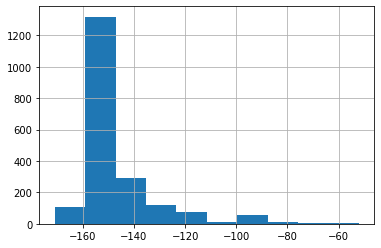

In [27]:
features.days_since_last_fin.hist()